# **Layout Parser Model Training**

# Detectron2

Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark

### Installation
* detectron2 is not pre-installed in this kaggle docker, so let's install it.
* we need to know CUDA and pytorch version to install correct detectron2.

In [1]:
!nvidia-smi

Sat Feb  8 20:06:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.1+cu110 True


* It seems CUDA=11.0 and torch==1.7.0 is used in this kaggle docker image.
* See installation for details. https://detectron2.readthedocs.io/en/latest/tutorials/install.html

### Install Pre-Built Detectron2

In [4]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
     |████████████████████████████████| 6.4 MB 787 kB/s eta 0:00:01
     |████████████████████████████████| 154 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 79 kB 5.9 MB/s  eta 0:00:01
     |████████████████████████████████| 130 kB 31.4 MB/s eta 0:00:01
     |████████████████████████████████| 403 kB 50.4 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 65.1 MB/s eta 0:00:01
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61433 sha256=0c6148e2cd1dce91c830d27a1db5707f8dcdcb8d6d99091eb6fd93c54a5553db
  Stored in directory: /root/.cache/pip/wheels/af/cd/23/3fb62ec8606cb08cc18abb8d67bec255baf353623be889da1e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=cc4ec67cfe58e6e6bb336663b6b127fc710997b0

# importing libraries

In [5]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
#from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


# torch
import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<_Logger detectron2 (DEBUG)>

In [6]:
f = open('/kaggle/input/papers-images/train/train/samples.json',)
thing_classes  = []
thing_classes_id = {}
data_annotations=[]
data = json.load(f)
#----Images----
data_images=data['images']
#---annotations-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+hieght
         }
    data_annotations.append(annot_obj) 
#---categories-
for i in data['categories']:
    thing_classes.append(i['name'])
    thing_classes_id[i['name']]=i['id']
f.close()
print("thing_classes=",thing_classes)
print("thing_classes_id=",thing_classes_id)

thing_classes= ['text', 'title', 'list', 'table', 'figure']
thing_classes_id= {'text': 1, 'title': 2, 'list': 3, 'table': 4, 'figure': 5}


In [7]:
thing_classes= ['None','text', 'title', 'list', 'table', 'figure']

In [8]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 20


,image_id,file_name,width,height
0,348952,PMC5491943_00004.jpg,596,794
1,384435,PMC5302692_00002.jpg,612,792
2,353156,PMC3863500_00003.jpg,601,792


In [9]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 193


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,3377124,346767,1,37.59,360.34,288.66,401.70
1,3377125,346767,1,37.59,433.64,288.66,454.02
2,3377126,346767,1,306.60,381.37,557.66,422.61


# configs

In [10]:
imgdir="/kaggle/input/papers-images/train/train"

debug=False
split_mode="valid20" # all_train Or  valid20 
image_Width=601
image_Height=792

In [11]:
def get_PL_data_dicts(
    imgdir: Path,
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"
   
):
    if debug:
            train_meta = train_meta.iloc[:100]  # For debug...
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    filename = str(f'{imgdir}/{file_name}')
                    record["file_name"] = filename
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)
                    
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts             

In [12]:
Data_Resister_training="PL_data_train";
Data_Resister_valid="PL_data_valid";

if split_mode == "all_train":
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)
    
    
elif split_mode == "valid20":

    n_dataset = len(train_meta)
    n_train = int(n_dataset * 0.95)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(12)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=train_inds,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=valid_inds,
            debug=debug,
            data_type="val"
            ),
        )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

n_dataset 20 n_train 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
print("dicts training size=",len(dataset_dicts_train),"################  dicts valid size=",len(dataset_dicts_valid))

dicts training size= 19 ################  dicts valid size= 1


In [15]:
dataset_dicts_valid[0]

{'file_name': '/kaggle/input/papers-images/train/train/PMC5618295_00004.jpg',
 'image_id': 393872,
 'width': 596,
 'height': 842,
 'annotations': [{'bbox': [76.24, 385.32, 519.14, 505.61],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [76.21, 506.62, 519.99, 681.23],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [76.24, 682.53, 519.99, 762.29],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [97.5, 275.51, 498.6, 350.71],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [94.71, 89.91, 501.39, 264.27],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5.0},
  {'bbox': [76.53, 365.58, 212.99, 377.89],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2.0}]}

# Data Augmentation

In [16]:
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [17]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 

cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 0
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.WEIGHTS="/kaggle/input/layout-parser-weights/Weights/mask_rcnn_R_50_FPN_3x/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025

cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 1000) # must be less than  MAX_ITER 
cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
trainer = AugTrainer(cfg) 
#trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/08 20:07:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/20 [00:00<?, ?it/s]

[02/08 20:07:32 d2.data.build]: Removed 0 images with no usable annotations. 19 images left.
[02/08 20:07:32 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    None    | 0            |    text    | 133          |   title    | 33           |
|    list    | 7            |   table    | 6            |   figure   | 8            |
|            |              |            |              |            |              |
|   total    | 187          |            |              |            |              |
[02/08 20:07:32 d2.data.build]: Using training sampler TrainingSampler
[02/08 20:07:32 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[02/08 20:07:32 d2.data.common]: Serialized dataset takes 0.02 MiB
[02/08 20:07:41 d2.engine.train_loop]: Starting training from itera

  0%|          | 0/20 [00:00<?, ?it/s]

[02/08 20:15:26 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    None    | 0            |    text    | 4            |   title    | 1            |
|    list    | 0            |   table    | 0            |   figure   | 1            |
|            |              |            |              |            |              |
|   total    | 6            |            |              |            |              |
[02/08 20:15:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/08 20:15:26 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[02/08 20:15:26 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [02/08 20:15:26 d2.engine.defaults]: No evalu

  0%|          | 0/20 [00:00<?, ?it/s]

[02/08 20:23:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/08 20:23:14 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[02/08 20:23:14 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [02/08 20:23:14 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


In [18]:
evaluator = COCOEvaluator(Data_Resister_training, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
val_loader = build_detection_test_loader(cfg, Data_Resister_training)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/08 20:23:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/08 20:23:14 d2.evaluation.coco_evaluation]: 'PL_data_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/08 20:23:14 d2.data.datasets.coco]: Converting annotations of dataset 'PL_data_train' to COCO format ...)


  0%|          | 0/20 [00:00<?, ?it/s]

[02/08 20:23:14 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/08 20:23:14 d2.data.datasets.coco]: Conversion finished, #images: 19, #annotations: 187
[02/08 20:23:14 d2.data.datasets.coco]: Caching COCO format annotations at './output/PL_data_train_coco_format.json' ...


  0%|          | 0/20 [00:00<?, ?it/s]

[02/08 20:23:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/08 20:23:14 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[02/08 20:23:14 d2.data.common]: Serialized dataset takes 0.02 MiB
[02/08 20:23:14 d2.evaluation.evaluator]: Start inference on 19 batches
[02/08 20:23:15 d2.evaluation.evaluator]: Inference done 11/19. Dataloading: 0.0295 s/iter. Inference: 0.0623 s/iter. Eval: 0.0003 s/iter. Total: 0.0921 s/iter. ETA=0:00:00
[02/08 20:23:16 d2.evaluation.evaluator]: Total inference time: 0:00:01.322987 (0.094499 s / iter per device, on 1 devices)
[02/08 20:23:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.062308 s / iter per device, on 1 devices)
[02/08 20:23:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[02/08 20:23:16 d2.evaluation.coco_evaluation]: Saving results to

OrderedDict([('bbox',
              {'AP': 54.771026913700105,
               'AP50': 78.55656714508748,
               'AP75': 66.38226423603612,
               'APs': 46.70443607905941,
               'APm': 29.247792169542357,
               'APl': 49.177271187576736,
               'AP-None': nan,
               'AP-text': 71.25681806224736,
               'AP-title': 55.703152805100444,
               'AP-list': 16.58163234801741,
               'AP-table': 63.05280528052805,
               'AP-figure': 67.26072607260727})])

In [19]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
data_time,0.136451,0.146273,0.145957,0.148181,0.163339,0.147799,0.154660,0.146895,0.144883,0.142880
eta_seconds,898.950465,889.870158,889.204682,887.629843,881.280001,873.629666,865.981150,856.669525,847.357900,836.785300
fast_rcnn/cls_accuracy,0.843750,0.875000,0.875000,0.875000,0.937500,0.937500,0.906250,0.875000,0.875000,0.875000
fast_rcnn/false_negative,0.250000,0.250000,0.250000,0.250000,0.250000,0.125000,0.250000,0.000000,0.250000,0.250000
fast_rcnn/fg_cls_accuracy,0.500000,0.625000,0.500000,0.750000,0.750000,0.875000,0.750000,0.750000,0.750000,0.750000
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000
loss_box_reg,0.444296,0.608705,0.596367,0.661097,0.569695,0.473085,0.556113,0.511920,0.425795,0.460813
loss_cls,0.628910,0.376710,0.441346,0.387212,0.303217,0.255428,0.377676,0.289976,0.302316,0.327285
loss_rpn_cls,0.055635,0.066394,0.058480,0.049027,0.031944,0.035681,0.033061,0.029466,0.025828,0.023216
loss_rpn_loc,0.192320,0.220220,0.213272,0.192443,0.159616,0.159152,0.151508,0.164287,0.148091,0.140799


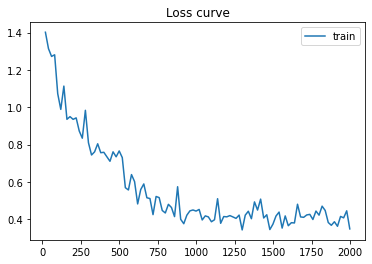

In [20]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

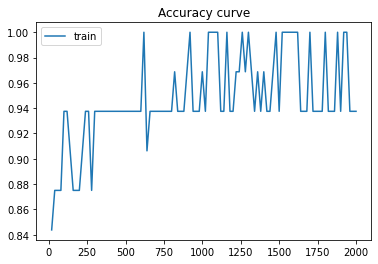

In [21]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

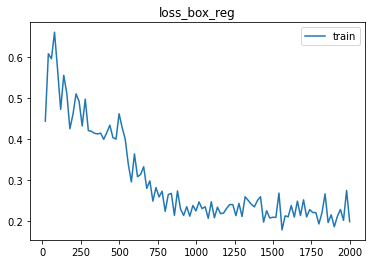

In [22]:
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["loss_box_reg"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("loss_box_reg")
plt.show()

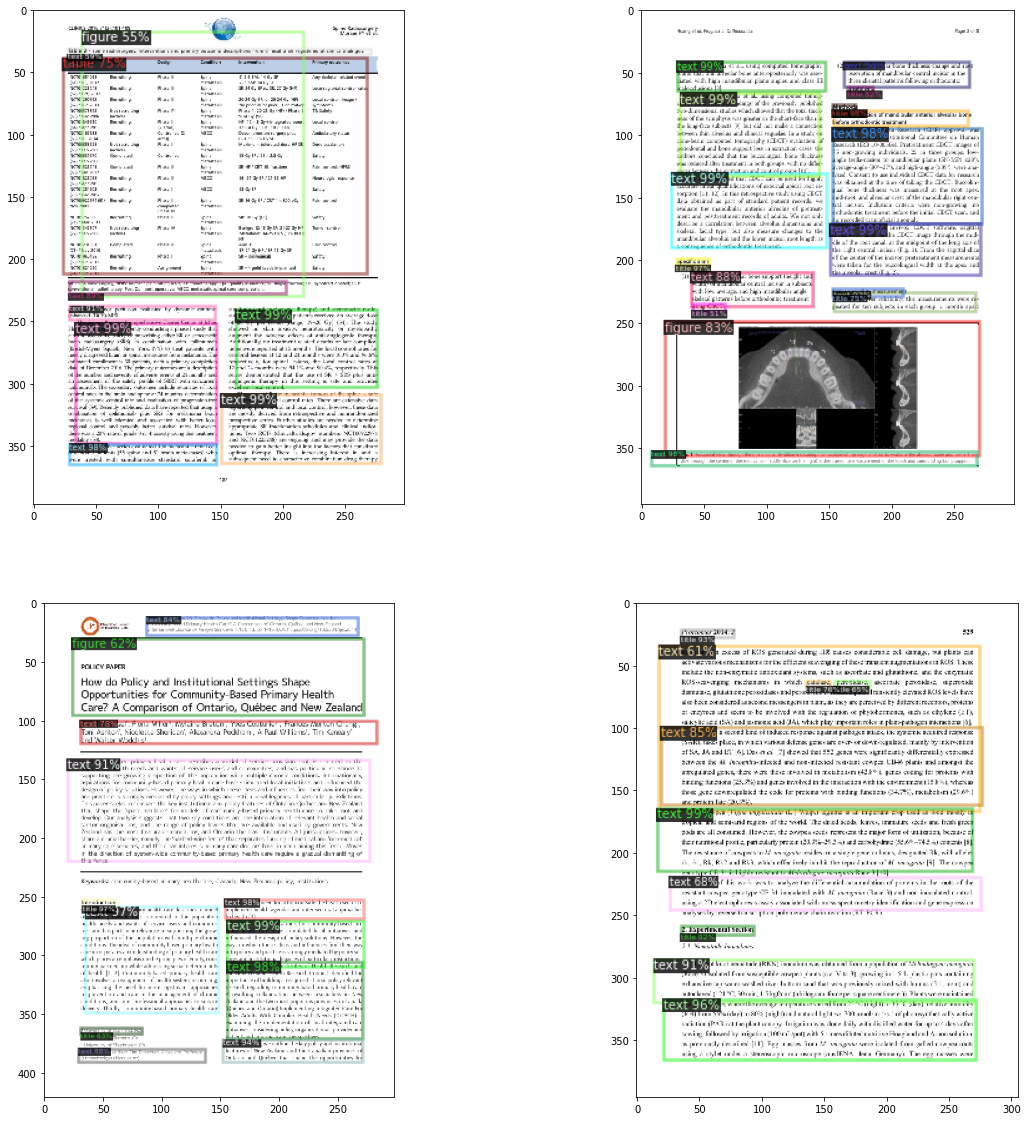

In [26]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
#cfg.DATASETS.TEST = ("Data_Resister_training", )
predictor = DefaultPredictor(cfg)

###############################################################

fig, ax = plt.subplots(2, 2, figsize =(20,20))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = random.sample(dataset_dicts_train, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_train,scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)

### References
* https://layout-parser.readthedocs.io/en/latest/notes/installation.html
* https://github.com/Layout-Parser/layout-model-training/blob/master/tools/train_net.py
* https://towardsdatascience.com/auto-parse-and-understand-any-document-5d72e81b0be9
* https://layout-parser.readthedocs.io/en/latest/api_doc/models.html